In [1]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
from datetime import timedelta

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts 

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Custom function packages
import vector_tools as vt

In [316]:
#Raw data
adv1Despiked = xr.open_dataset('ADV/adv1_despiked.nc')
adv2Despiked = xr.open_dataset('ADV/adv2_despiked.nc')

In [2]:
#Import deployment 1 data
adv1Int = xr.open_dataset('ADV/adv1Int.nc')
adv1Patch = xr.open_dataset('ADV/adv1Patch.nc')
adv1IntAvg = xr.open_dataset('ADV/adv1IntAvg.nc')

#Import deployment 2 data
adv2Int = xr.open_dataset('ADV/adv2Int.nc')
adv2Patch = xr.open_dataset('ADV/adv2Patch.nc')
adv2IntAvg = xr.open_dataset('ADV/adv2IntAvg.nc')

#Import temperature data
temp = xr.open_dataset('Temperature/temp_w_rho.nc')

In [31]:
((adv2IntAvg.Depth.mean()+.6) + (adv1IntAvg.Depth.mean()+.6)) / 2

<xarray.DataArray 'Depth' ()>
array(10.39500509)

In [29]:
adv1IntAvg.Depth.max()

<xarray.DataArray 'Depth' ()>
array(11.03593587)

# Spectral analysis and turbulent dissipation estimates
### Estimating dissipation
- Using quality controlled adv data, turbulent dissipation (eps) can be estimated through velocity spectra
- Steps to estimate dissipation:
    - Determine proper detrend window and segment size for spectra
    - Determine where the surface gravity wave band is by converting pressure spectra to vertical velocity via linear wave theory
    - Determine the noise floor by averaging spectra from >3Hz 
    - Use lower boundary frequency (surface wave band) and upper boundary frequency (noise floor) to estimate the inertial subrange (ISR)
    - Fit a power curve to ISR and evaluate if the slope and slope error is comparable with -5/3 trend
    - If acceptable, use spectra from the fitted slope to estimate eps via equation A14 from Gerbi et al. 2009
    - Use linear regression to test that eps values are relatively constant over the estimated ISR

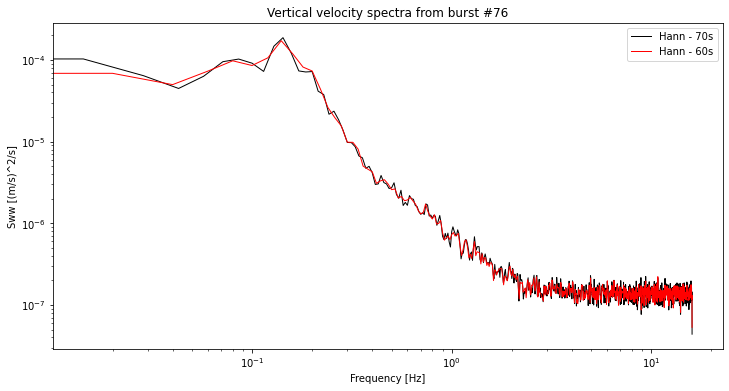

In [6]:
# Hanning window provides best dof
# 50s window smooths out alot of lower frequency wave noise, and some spectra within ISR
# 60s window provides resolution of 70s without as much chatter
# 70s yield good resolution but many spikes at higher frequencies

# Compare window types and segment lengths

# Select single "good" data burst
# Burst 76 provides a good looking spectral curve, so it will be used
# to test eps estimate parameters
burst_number = 76
ds = adv1IntAvg.copy(deep=True)
burst = ds.Up.where((ds.BurstNum.isin(burst_number)) & (ds.Up.isnull()==False), drop = True)

# Fedderson 2010 and 2007 uses combination of 50s and 70s windows
# Both Hann and Hamming windows used through the literature
Fw_hann50s, Sw_hann50s = welch(burst, fs=32, nperseg= 1600, window='hann') # Vertical velocity spectra
Fw_hann60s, Sw_hann60s = welch(burst, fs=32, nperseg= 1920, window='hann')
Fw_hann70s, Sw_hann70s = welch(burst, fs=32, nperseg= 2240, window='hann')

plt.figure(figsize = (12,6))
plt.title('Vertical velocity spectra from burst #' + str(burst_number))
plt.loglog(Fw_hann70s, Sw_hann70s, '-k', lw = 1)
#plt.loglog(Fw_hann60s, Sw_hann60s, '-g', lw = 1)
plt.loglog(Fw_hann50s, Sw_hann50s, '-r', lw = 1)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Sww [(m/s)^2/s]')
plt.legend(['Hann - 70s','Hann - 60s'])

In [49]:
dof_hann50s = (8/3) * (38400/800)
dof_hann60s = (8/3) * (38400/960)
dof_hamm50s = (2.5164) * (38400/800)
dof_hamm60s = (2.5164) * (38400/960)

print(str(dof_hann50s),str(dof_hann60s),str(dof_hamm50s),str(dof_hamm60s))

128.0 106.66666666666666 120.7872 100.656


### Estimating the surface gravity wave band

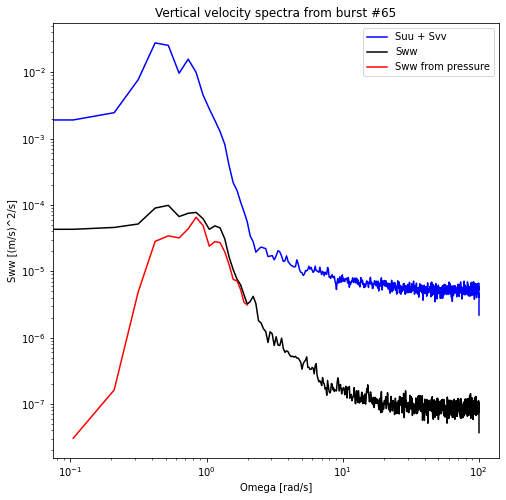

In [6]:
# A Hann window with 60s segments yields a good balance between smoothing of 50s and resolution from 70s

# First, determine the surface gravity wave band by converting pressure spectra to vertical velocity
# spectra via linear wave theory

# Good bursts = 8,29,41,42,52,55,58,59,75,76,82,90,91,106,116
burst_number = 65
ds = adv1Int.copy(deep=True)
burstTime = ds.time.where((ds.BurstNum.isin(burst_number)) & (ds.Up.isnull()==False), drop=True)
rho = np.mean(temp.Rho.sel(depth=4,time=slice(burstTime[0],burstTime[-1]))) + 1000

vt.spectraPlotter(adv1Int, burst_number, rho)

- Despite the pressure sensor being located at 10m of depth, converted spectra follow velocity well
- Pressure sensor noise floor causes spectra to continuously grow in spectral density, skewing results
- A hard cutoff is used at the local minimum where this noise floor begins
- Jones and Monosmith (2008) show that pressure signal falls rapidly after reaching peak energy
- However, as an extra precaution, another 1/4Hz should be added to the cutoff to be certain that the surface wave band is avoided

# Estimating turbulent dissipation

### Finding the inertial subrange (ISR) and estimating eps with various methods
- Fit best power slope fit within pre-determined boundaries
- Fit -5/3 slope to set of points with and select range with smallest misfit
    - Minimum range seems to be anywhere from 1hz to 2.5hz long
- Iterative kernal density estimate used by Wheeler and Giddings

### Calculating dissipation
## $\epsilon$ = ${\langle\frac{S_{ww}(\omega) \omega^\frac{5}{3}}{\alpha J_{33}(\omega)}\rangle} ^\frac{3}{2}$

- $S_{ww}(\omega)$ = Vertical velocity spectra at omega
- $\omega$ = radian frequency being evaluated
- $\alpha$ = 1.5 (Kolmogoroff's constant)
- $J_{33}(\omega)$ = integral over 3D wavenumber space that depends on the mean flow and wave-orbital velocities
- $\epsilon$ is estimated over all radian frequencies within proposed inertial subrange

### Quality controlling the epsilon estimates
- To accept an estimate of epsilon:
    - isrInt (intercept) > isrIntErr (error in the intercept) (Jones and Monosmith 2008)
    - Noise is < half the magnitude of spectrum at minimum frequency (omega_min) (Gerbi et al. 2009)
    - Slope fit and slope error fall within acceptable boundaries (Feddersen 2010)
        - (mu - 2mu_err - .06 < -5/3 < mu + 2mu_err + .06)
    - Linear regression of eps estimates within isr has a slope that is statistically indistinguishable from 0 Feddersen 2010
        - scipy.linregress p-value indicates test where the H0 is that slope is indistinguishable from 0
        - Therefore, we want to accept the null hypothesis
        - If p-value > .05, we can't reject the null
    - R ratio near unity (.5 < R < 2) Feddersen 2010

In [ ]:
#Try fixed ISR approach from Feddersen 2010
Jlm = pd.read_csv('ADV/Jlm1IntAvg.csv').J_33 #Jlm value for each burst
lowerBound = .8 
upperBound = 2.5
eps1IntAvg = fixedEpsCalc(adv1IntAvg, Jlm, lowerBound, upperBound)

In [ ]:
#Using a dynamic window that selects best on best fitting ISR
eps1Int = vt.EpsCalc(adv1Int, temp, selBurstNumbers = None, nperseg=1920, minimumGap=1, noiseFrequency = 3.5)
eps1IntAvg = vt.EpsCalc(adv1IntAvg, temp, selBurstNumbers = None, nperseg=1920, minimumGap=1, noiseFrequency = 3.5)

eps2Int = vt.EpsCalc(adv2Int, temp, selBurstNumbers = None, nperseg=1920, minimumGap=1, noiseFrequency = 3.5)
eps2IntAvg = vt.EpsCalc(adv2IntAvg, temp, selBurstNumbers = None, nperseg=1920, minimumGap=1, noiseFrequency = 3.5)

In [ ]:
#Export data
eps1Int.to_netcdf('ADV/eps1Int_final.nc')
eps1IntAvg.to_netcdf('ADV/eps1IntAvg_final.nc')
eps2Int.to_netcdf('ADV/eps2Int_final.nc')
eps2IntAvg.to_netcdf('ADV/eps2IntAvg_final.nc')

# Plotting Dissipation

In [3]:
#Import data
eps1Int = xr.open_dataset('ADV/eps1Int_final.nc')
eps1IntAvg = xr.open_dataset('ADV/eps1IntAvg_final.nc')
eps2Int = xr.open_dataset('ADV/eps2Int_final.nc')
eps2IntAvg = xr.open_dataset('ADV/eps2IntAvg_final.nc')

### Overview of deployment 1
Deployment 1 of the ADV spans the course of August 2nd to August 12th in 2022. The temperature profile of the water column during the first half of the deployment shows a trend of increasing temperature until reaching a peak on the 6th. After this temperature peak, there is a general decrease in temperature over time. Diurnal temperature drops are relatively small in the first half of the deployment when compared to the latter half. While these smaller cooling events appear as noise when compared to the rest of the temperature time series, the primary velocities from the ADV show significant onshore currents. Starting around the 5th, the cooling events grow more dramatic, with steeper declines in temperature and sharp transitions from offshore to onshore transport by magnitudes of up to .3[m/s] The most intense cooling events in terms of temperature drop and onshore velocity occur just after the 6th, middle of the 7th, and middle of the 8th. These cooling events yield the largest estimates of turbulent kinetic energy dissipation rate ($\epsilon$), indicating that the rapid influx of cool, offshore water into the kelp forest has a noticeable effect on turbulence. Beyond the middle of the 8th, data from the ADV became inconsistent with high correlation and signal-to-noise ratios, invalidating most $\epsilon$ measurements towards the end of the deployment.

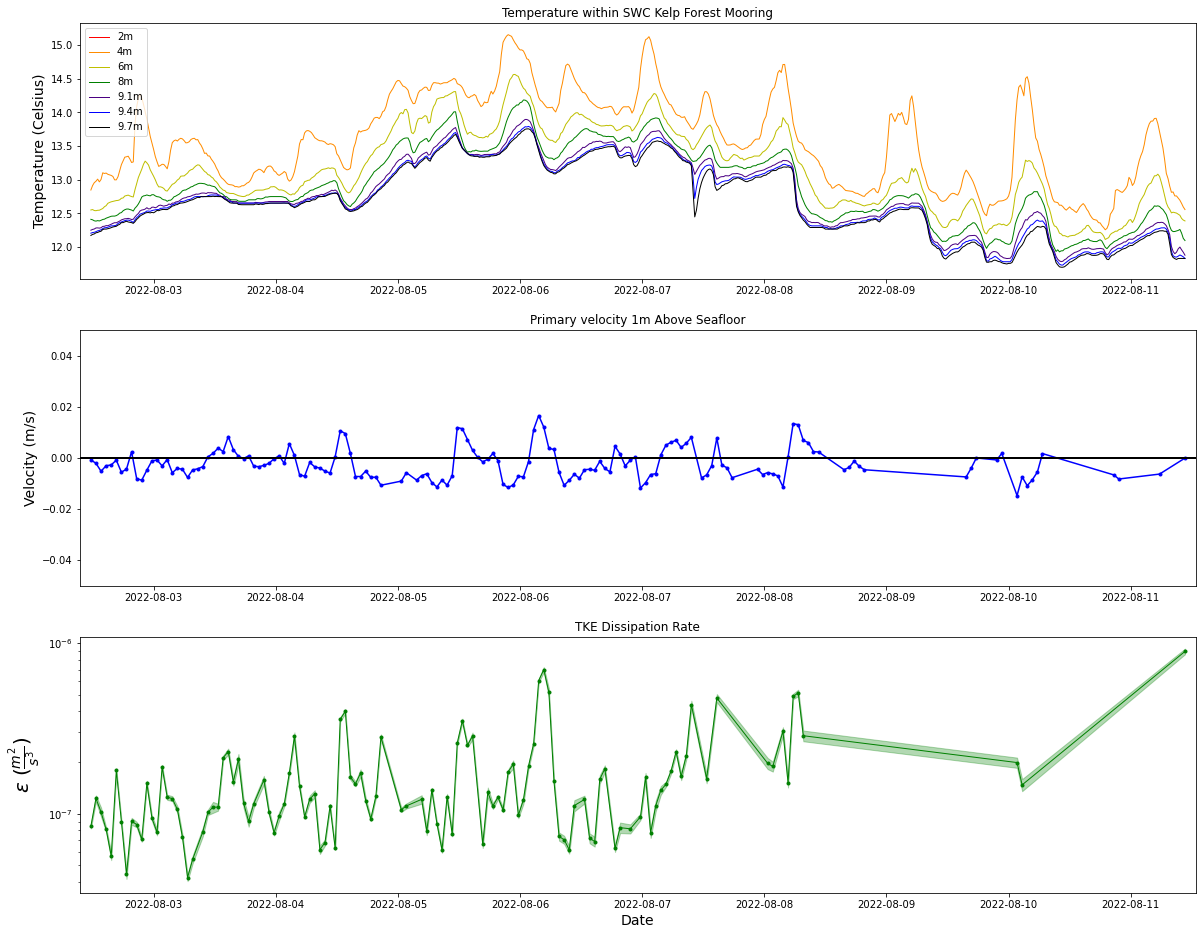

In [20]:
vt.vecEpsPlotter(adv1IntAvg, temp, eps1IntAvg, timeFrame = None)
                           #saveFig=True, filename = 'Plots/Deployment2_vec_overview', returnBnum = True)

### Cooling events of deployment 1
Over the course of three days from August 4th to the 7th, multiple cooling events occur

array([43., 44., 45., 52., 53., 54., 55., 75., 76., 77., 78., 80., 81.,
       88., 89., 90., 91., 92., 93., 94., 95., 96.])

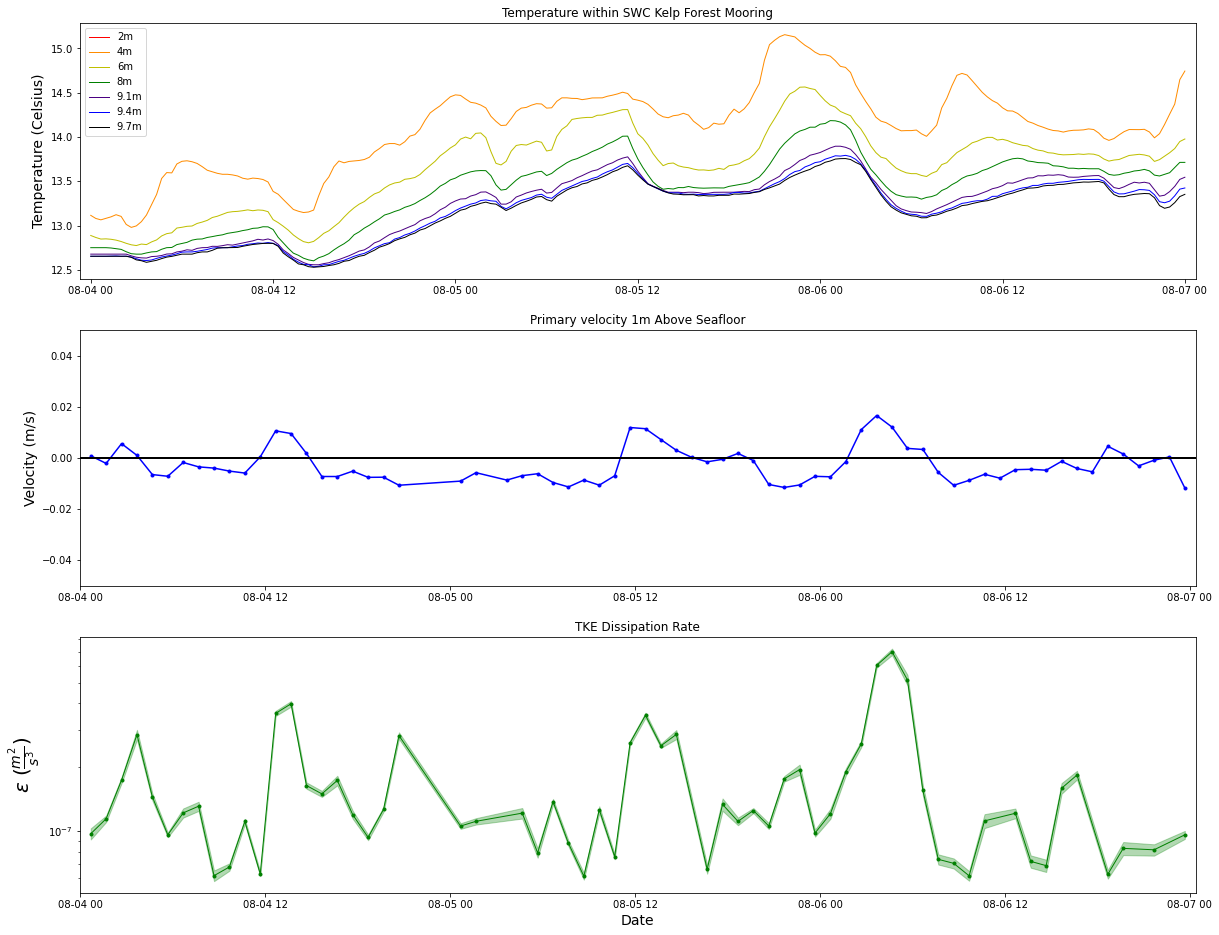

In [22]:
dep1CEB = vt.vecEpsPlotter(adv1IntAvg, temp, eps1IntAvg, timeFrame = ['2022-08-04T00:00:00.000000000','2022-08-07T00:00:00.000000000'],
                           saveFig=True, filename = 'Plots/Deployment1_804_807', returnBnum = True)
dep1CEB = dep1CEB[np.array([3,4,5,12,13,14,15,30,31,32,33,34,35,42,43,44,45,46,47,48,49,50])]
dep1CEB

In [ ]:
vt.vecEpsPlotter(adv1IntAvg, temp, eps1IntAvg, timeFrame = ['2022-08-05T00:00:00.000000000','2022-08-07T00:00:00.000000000'])#, saveFig=True, filename = 'Plots/0807_0809_vec_overview')

array([43., 44., 45., 52., 53., 54., 55., 75., 76., 77., 78., 80., 81.,
       88., 89., 90., 91., 92., 93., 94., 95., 96.])

In [30]:
eps2IntAvg.bNum.where(eps2IntAvg.eps >= 7e-7, drop=True)

<xarray.DataArray 'bNum' (bNum: 6)>
array([  7.,  55., 168., 249., 279., 352.])
Coordinates:
  * bNum     (bNum) float64 7.0 55.0 168.0 249.0 279.0 352.0

In [ ]:
#Cooling event bursts
#Deployment 1:[52, 53], [75,76,77], [91,92,93]
#Deployment 2:[6,7,8], [55], [168,169]

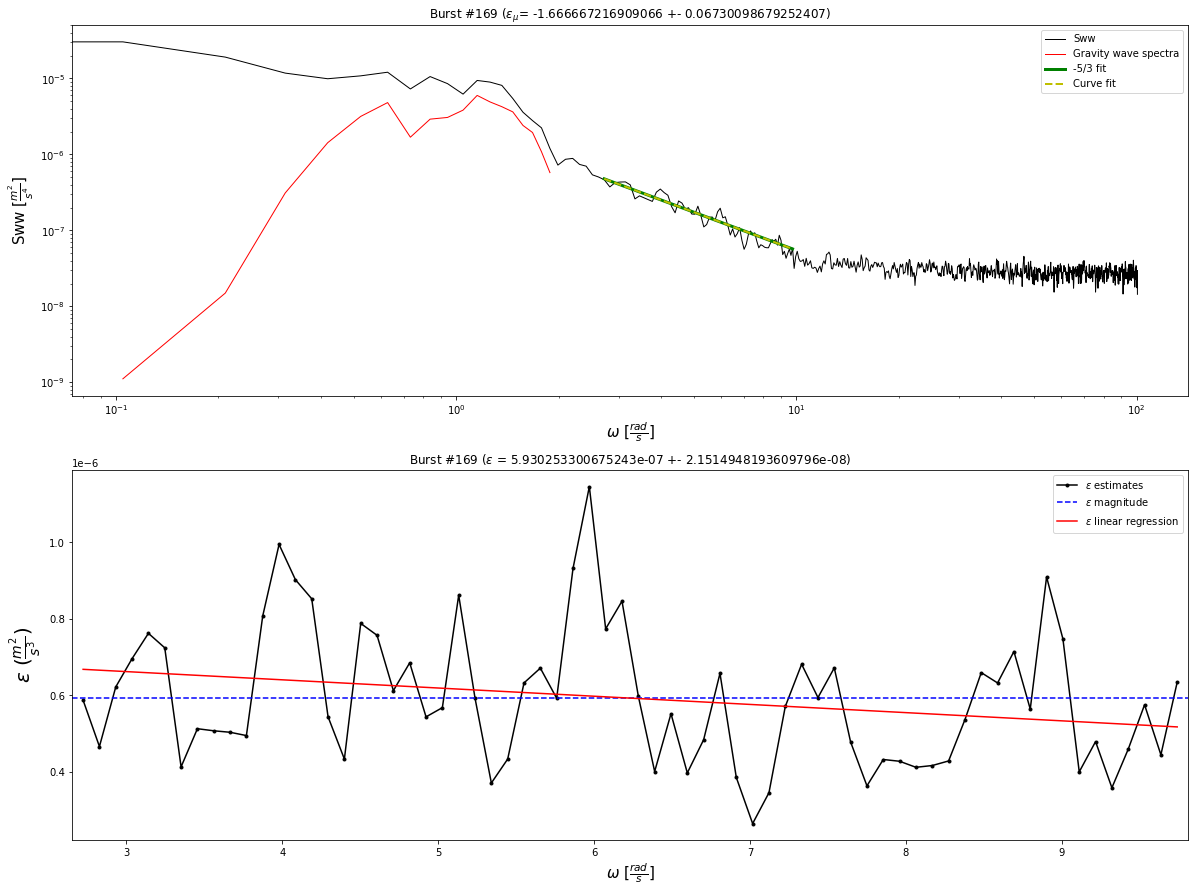

In [43]:
vt.epsSpectraPlotter(eps2IntAvg, 169)

In [35]:
eps2IntAvg.Int

<xarray.DataArray 'Int' (bNum: 320)>
array([3.77980979e-07, 5.70400266e-07, 4.36182069e-07, 1.67033913e-06,
       4.01482824e-06, 3.10319265e-06,            nan, 2.17054070e-06,
                  nan, 6.33042542e-07, 6.79993252e-07, 6.37640245e-07,
       4.76696539e-07,            nan, 4.22316249e-07, 5.42183547e-07,
       3.82064396e-07, 5.42205904e-07, 1.06897172e-06, 3.82582621e-07,
       6.92211008e-07, 5.23687327e-07, 1.91961981e-06, 1.57566886e-06,
       3.16391051e-07,            nan, 4.73187162e-07, 4.10349932e-07,
                  nan, 6.46606972e-07, 6.23907298e-07,            nan,
                  nan, 7.06925093e-07, 4.33416474e-07, 7.18484541e-07,
                  nan, 5.79104158e-07, 5.45318103e-07, 1.44181282e-06,
       6.87880936e-07, 6.36895471e-07, 5.44212734e-07, 4.50278593e-07,
                  nan, 6.42108966e-07, 6.66979975e-06, 1.96499159e-06,
                  nan,            nan, 5.24732367e-07, 6.08877708e-07,
                  nan, 4.84826875e-07, 7.40945740e-07, 7.09946395e-07,
       3.82563157e-07, 5.80437432e-07, 7.71631797e-07, 6.62922534e-07,
       8.80383323e-07, 1.15995279e-06, 1.88882161e-06, 1.87393794e-06,
                  nan,            nan,            nan, 6.47198830e-07,
       6.82709371e-07,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       3.64949462e-07,            nan,            nan, 7.39926016e-07,
...
       7.36843827e-07, 8.70223178e-07, 5.48420202e-07, 3.61169114e-07,
       2.95556487e-07, 4.93814533e-07, 2.76454493e-07, 3.81636463e-07,
       3.77157485e-06, 1.11298255e-06,            nan, 6.91363371e-07,
       7.74132166e-07, 6.86594659e-07,            nan, 1.00524281e-06,
       4.56333194e-07, 6.08942078e-07, 4.34792340e-07, 1.11911754e-06,
       6.30806554e-07, 7.04681498e-07, 9.28089579e-07, 7.93912208e-07,
       6.05179916e-07, 6.68420919e-07, 4.79958588e-07, 5.58471670e-07,
       4.02102257e-07, 7.84408726e-07, 5.45742128e-07, 1.33314350e-06,
       1.74763030e-06, 2.39831904e-06, 1.69334527e-06, 1.67929893e-06,
       1.22165314e-06, 8.26931321e-07, 4.67652581e-07, 1.04503198e-06,
       6.77914909e-07, 6.65374973e-07, 1.30246082e-06, 7.36419535e-07,
       5.74759415e-07, 9.67679807e-07, 8.06728891e-07, 1.12568848e-06,
       7.01726248e-07, 9.64370438e-07, 1.10909513e-06,            nan,
       7.80178825e-07,            nan, 6.62821839e-07, 6.93222361e-07,
       1.08173181e-06, 1.87826959e-06, 1.29350887e-06, 1.25721855e-06,
       1.30141796e-06, 8.50336100e-07, 1.20288982e-06, 6.40926256e-07,
       7.43389177e-07, 7.58965286e-07, 7.03375423e-07, 6.29503488e-07,
       1.02881047e-06, 3.68080448e-06, 7.07051020e-07, 5.09599828e-07,
       2.65022709e-06, 1.34383710e-06,            nan,            nan,
                  nan, 9.56183595e-07, 6.49834197e-07, 1.97046347e-06])
Coordinates:
  * bNum     (bNum) float64 3.0 4.0 5.0 6.0 7.0 ... 361.0 362.0 363.0 365.0

In [36]:
eps2IntAvg.eps

<xarray.DataArray 'eps' (bNum: 320)>
array([6.61053960e-08, 9.34918156e-08, 1.14035196e-07, 3.22858886e-07,
       9.58206169e-07, 5.95968797e-07,            nan, 5.87913267e-07,
                  nan, 2.24641652e-07, 1.26579623e-07, 9.68253950e-08,
       8.37986856e-08,            nan, 7.04782838e-08, 1.82400588e-07,
       7.52837594e-08, 2.91023189e-07, 1.56492775e-07, 7.62228427e-08,
       2.49781961e-07, 1.36779294e-07, 3.05112006e-07, 2.47569447e-07,
       6.63493739e-08,            nan, 1.31454720e-07, 8.65836087e-08,
                  nan, 1.20217541e-07, 1.44199536e-07,            nan,
                  nan, 1.24422216e-07, 9.64909964e-08, 1.38098181e-07,
                  nan, 1.84018648e-07, 2.70024215e-07, 2.10484424e-07,
       1.13708660e-07, 2.14302026e-07, 1.43369800e-07, 6.70435938e-08,
                  nan, 9.10095392e-08, 1.87018828e-06, 4.76799958e-07,
                  nan,            nan, 7.87668069e-08, 2.57334920e-07,
                  nan, 8.33687818e-08, 1.46146590e-07, 1.33070533e-07,
       6.92477583e-08, 1.16968992e-07, 1.36612729e-07, 1.89764555e-07,
       1.41684719e-07, 2.14224971e-07, 3.62143807e-07, 3.75098419e-07,
                  nan,            nan,            nan, 1.41016800e-07,
       1.55305508e-07,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       8.47565033e-08,            nan,            nan, 2.47450558e-07,
...
       7.51170907e-08, 9.65838111e-08, 6.75940151e-08, 3.76582343e-08,
       4.43957846e-08, 6.12947070e-08, 5.61947333e-08, 3.52110052e-08,
       7.31712224e-07, 2.04313587e-07,            nan, 8.57002819e-08,
       9.43739586e-08, 1.86144273e-07,            nan, 1.21692906e-07,
       4.92349295e-08, 7.65726159e-08, 6.51229712e-08, 2.43747839e-07,
       6.53803502e-08, 7.70287770e-08, 1.02303132e-07, 1.18920101e-07,
       1.08062035e-07, 1.01450647e-07, 5.44069060e-08, 7.76563977e-08,
       4.38180898e-08, 1.16342220e-07, 1.03836665e-07, 2.28370306e-07,
       2.67919102e-07, 3.60608565e-07, 2.40676821e-07, 2.25077673e-07,
       2.75138600e-07, 1.44044268e-07, 5.63639987e-08, 1.21704088e-07,
       7.37756507e-08, 8.24278409e-08, 2.28424384e-07, 7.91461826e-08,
       5.86749225e-08, 1.08037339e-07, 9.46541167e-08, 1.43955245e-07,
       9.28997404e-08, 9.67548966e-08, 1.36369073e-07,            nan,
       9.89624202e-08,            nan, 8.20574473e-08, 9.20828116e-08,
       1.35003655e-07, 2.81880620e-07, 1.55309236e-07, 1.39561252e-07,
       1.48771921e-07, 1.02472865e-07, 1.72794463e-07, 8.45972133e-08,
       3.36420836e-07, 9.89029951e-08, 9.06523260e-08, 7.36402955e-08,
       1.09323413e-07, 8.51242365e-07, 1.02416551e-07, 5.40169044e-08,
       4.96525473e-07, 1.71002892e-07,            nan,            nan,
                  nan, 2.17528175e-07, 2.60125387e-07, 4.04379152e-07])
Coordinates:
  * bNum     (bNum) float64 3.0 4.0 5.0 6.0 7.0 ... 361.0 362.0 363.0 365.0